**Warning:** This notebook is 'deprecated', as now we're working on the 'MLencoding' class which is demoed in its own notebook. This one might be useful if you want some tips on implementing these things yourself.  


# Beyond GLMs
This notebook accompanies "Modern Machine Learning Far Outperforms GLMs at Predicting Spikes". We implement various Machine Learning algorithms for spike prediction and offer this as a Python template.

### Table of contents
0. Loading data
0. Define helper functions for scoring and cross-validation
0. Define Models
    0. GLM
    0. XGBoost
    0. Neural Network
    0. Random Forest
    0. Ensemble
0. Nested cross-validation (for evaluating the ensemble)
0. Model Comparison
    0. M1 original features
    0. M1 engineered features
    0. M1 all neurons
0. Appendix 1: Hyperparameter optimization
0. Appendix 2: Running R's glmnet in python



## Dependencies
Basics
- numpy
- pandas
- scipy
- matplotlib

Methods
- sklearn
- pyglmnet (glm)
- xgboost
- theano (NN)
- keras (NN)

Other
- BayesOpt (Bayesian optimization for better hyperparameters)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy.io

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

#for plots
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.xaxis.set_tick_params(size=6)
    ax.yaxis.set_tick_params(size=6)

colors=['#F5A21E', '#02A68E', '#EF3E34', '#134B64', '#FF07CD','b']


# 1. Data
Below we load two datasets available on CRCNS: a [Macaque M1](http://crcns.org/data-sets/movements/dream/downloading-dream) (from [Stevenston et al. 2011](http://jn.physiology.org/content/106/2/764.short)) and a [Rat Hippocampus](http://crcns.org/data-sets/hc/hc-2/about-hc-2) from [Mizuseki et al. 2009](http://www.ncbi.nlm.nih.gov/pubmed/19874793).

The data has been organized in Matlab into neat arrays for easy loading here.

We will soon want a single numpy array representing the external covariates, and a single numpy vector representing the neural response. The data array X will be of dimensions (n, p), where n is the number of time bins and p is the number of covariates, and the response y will be of dimensions (n, ) . We use pandas as an intermediate tool for data organizing, but it's really not necessary - if using your own data just wrangle it into numpy arrays of proper dimension.

#### Load data

In [2]:
m1_imported = scipy.io.loadmat('../data/m1_stevenson_2011.mat')

### 1.1 Covariates

Pull into pandas dataframe. This allows us to easily access covariates by name.

In [3]:
data = pd.DataFrame()
data['time'] =  m1_imported['time'][0]
data['handPos_x'] =  m1_imported['handPos'][0]
data['handPos_y'] =  m1_imported['handPos'][1]
data['handVel_x'] =  m1_imported['handVel'][0]
data['handVel_y'] =  m1_imported['handVel'][1]
data.head() 

,time,handPos_x,handPos_y,handVel_x,handVel_y
0,12.591,0.002905,-0.303636,-0.011201,-0.006237
1,12.641,0.002260,-0.303869,-0.010743,-0.000833
2,12.691,0.002399,-0.303631,0.017680,0.012094
3,12.741,0.004010,-0.302399,0.044667,0.038700
4,12.791,0.006386,-0.300673,0.042202,0.017021


### Plot raw M1 data

This gives some intuitive feeling for the type of data we're working with.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


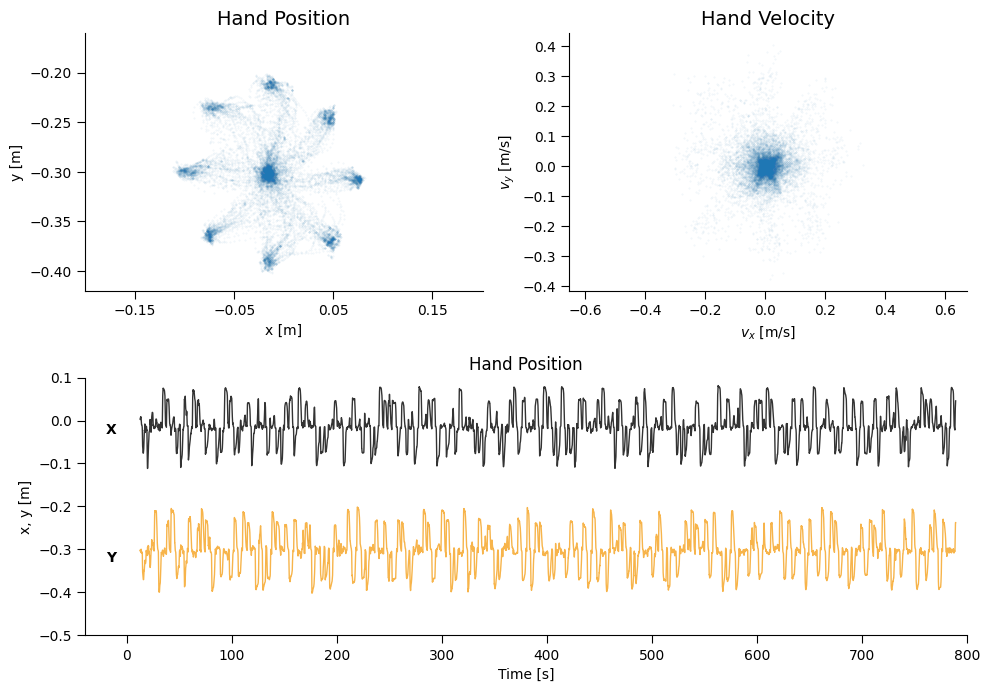

In [4]:
plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 10
plt.rcParams['font.weight'] = 'medium'
ldata = m1_imported['spikes'].shape

# Position scatter
ts = 14
gs0 = gridspec.GridSpec(3, 2)
plt.subplot(gs0[0,0])
simpleaxis(plt.gca())
plt.scatter(data['handPos_x'], data['handPos_y'], s=.1, alpha=.1)

plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.axis('equal')
plt.title('Hand Position',fontsize=ts)
plt.ylim([-0.42,-0.16])
plt.xlim([-0.15,0.15])
plt.xticks(np.arange(-0.15,0.2, .1))

# Velocity scatter
plt.subplot(gs0[0,1])
simpleaxis(plt.gca())
plt.scatter(data['handVel_x'], data['handVel_y'], s=.1, alpha=.1)

plt.xlabel('$v_x$ [m/s]')
plt.ylabel('$v_y$ [m/s]')
plt.axis('equal')
plt.title('Hand Velocity',fontsize=ts)

# Position trace
plt.subplot(gs0[1,:])
a=plt.gca()
simpleaxis(a)
a.text(-20,-.03,'X',weight='bold')
a.text(-20,-.33,'Y',weight='bold')
alpha = 0.8
lw = 1
plt.plot(data['time'], data['handPos_x'], 'k-', alpha=alpha, lw=lw)
plt.plot(data['time'], data['handPos_y'], '-', color=colors[0], alpha=alpha, lw=lw)
a.axis([-40,800,-0.5,0.1])

plt.xlabel('Time [s]')
plt.ylabel('x, y [m]')
plt.title('Hand Position')


plt.tight_layout()
plt.show()


#### Compute more covariates/features

These will be used as the 'engineered' features for improving the GLM's performance.

In [5]:
data['velDir'] = np.arctan2(data['handVel_y'], data['handVel_x'])
data['cos_velDir'] = np.cos(data['velDir'])
data['sin_velDir'] = np.sin(data['velDir'])
data['speed'] = np.sqrt(data['handVel_x'].values**2+data['handVel_y'].values**2)
r = np.arctan2(data['handPos_y'], data['handPos_x'])
data['cos_PosDir'] = np.cos(r)
data['sin_PosDir'] = np.sin(r)
data['radial_Pos'] = np.sqrt(data['handPos_x'].values**2+data['handPos_y'].values**2)
data.head()

,time,handPos_x,handPos_y,handVel_x,handVel_y,velDir,cos_velDir,sin_velDir,speed,cos_PosDir,sin_PosDir,radial_Pos
0,12.591,0.002905,-0.303636,-0.011201,-0.006237,-2.633523,-0.873685,-0.486491,0.012820,0.009568,-0.999954,0.303650
1,12.641,0.002260,-0.303869,-0.010743,-0.000833,-3.064245,-0.997010,-0.077271,0.010775,0.007437,-0.999972,0.303877
2,12.691,0.002399,-0.303631,0.017680,0.012094,0.599956,0.825360,0.564606,0.021420,0.007900,-0.999969,0.303641
3,12.741,0.004010,-0.302399,0.044667,0.038700,0.713933,0.755792,0.654812,0.059100,0.013258,-0.999912,0.302426
4,12.791,0.006386,-0.300673,0.042202,0.017021,0.383375,0.927408,0.374053,0.045505,0.021233,-0.999775,0.300741


# 3. Cross-validation
It's important to 

1. evaluate the performance of a method on held-out data
2. train as as much data as you can
3. have greater confidence in your results (see comic). 

These three criteria are met with [k-fold cross-validation (CV) ](https://en.wikipedia.org/wiki/Cross-validation_(statistics). The method `fit_cv` below returns a cross-validated pseudo-R2 score for an algorithm on a dataset.

__Note regarding ensemble:__ When training a stacked ensemble, it's good practice to train the 2nd-stage regressor on the predictions of 1st-stage regressors _not trained on data in the ensemble's test set_. Otherwise there could be some data leakage and overfitting; the 1st-stage regressors may have learned some of statistics of the noise specific to the test set, for example. It's not guaranteed this will happen, especially for larger datasets, but to be correct you can use the `fit_nested_cv` and accompanying `ensemble_cv` methods in __Appendix 1__.

[![crossvalidate](http://imgs.xkcd.com/comics/linear_regression.png)](http://xkcd.com/1725/)

In [19]:
from sklearn.model_selection import KFold


def poisson_pseudoR2(y, yhat, ynull):
    # This is our scoring function. Implements pseudo-R2
    yhat = yhat.reshape(y.shape)
    eps = np.spacing(1)
    L1 = np.sum(y*np.log(eps+yhat) - yhat)
    L1_v = y*np.log(eps+yhat) - yhat
    L0 = np.sum(y*np.log(eps+ynull) - ynull)
    LS = np.sum(y*np.log(eps+y) - y)
    R2 = 1-(LS-L1)/(LS-L0)
    return R2

def fit_cv(X, Y, algorithm, n_cv=10, verbose=1):
    """Performs cross-validated fitting. Returns (Y_hat, pR2_cv); a vector of predictions Y_hat with the
    same dimensions as Y, and a list of pR2 scores on each fold pR2_cv.
    
    X  = input data
    Y = spiking data
    algorithm = a function of (Xr, Yr, Xt) {training data Xr and response Yr and testing features Xt}
                and returns the predicted response Yt
    n_cv = number of cross-validations folds
    
    """
    if np.ndim(X)==1:
        X = np.transpose(np.atleast_2d(X))

    cv_kf = KFold(n_splits=n_cv, shuffle=True, random_state=42)
    skf  = cv_kf.split(X)

    i=1
    Y_hat=np.zeros(len(Y))
    pR2_cv = list()
    for idx_r, idx_t in skf:
        if verbose > 1:
            print( '...runnning cv-fold', i, 'of', n_cv)
        i+=1
        Xr = X[idx_r, :]
        Yr = Y[idx_r]
        Xt = X[idx_t, :]
        Yt = Y[idx_t]

        Yt_hat = eval(algorithm)(Xr, Yr, Xt)
        Y_hat[idx_t] = Yt_hat.ravel()

        pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
        pR2_cv.append(pR2)

        if verbose > 1:
            print( 'pR2: ', pR2)

    if verbose > 0:
        print("pR2_cv: %0.6f (+/- %0.6f)" % (np.mean(pR2_cv),
                                             np.std(pR2_cv)/np.sqrt(n_cv)))

    return Y_hat, pR2_cv


In [7]:

def plot_model_comparison(models_for_plot, models=[], color='r', title=None, labels=[],fs=12):
    """Just makes a comparision bar plot."""
    plt.plot([-1, len(models_for_plot)], [0,0],'--k', alpha=0.4)
    
    if not labels: 
        labels = models_for_plot

    mean_pR2 = list()
    sem_pR2 = list()

    for model in models_for_plot:
        PR2_art = models[model]['PR2']
        mean_pR2.append(np.mean(PR2_art))
        sem_pR2.append(np.std(PR2_art)/np.sqrt(np.size(PR2_art)))

    plt.bar(np.arange(np.size(mean_pR2)), mean_pR2, 0.8, align='center',
            ecolor='k', alpha=.9, color=color, ec='w', yerr=np.array(sem_pR2),
            tick_label=labels)
    plt.plot(np.arange(np.size(mean_pR2)), mean_pR2, 'k.', markersize=15)

    plt.ylabel('Pseudo-R2',fontsize=fs)
    simpleaxis(plt.gca())
    if title:
        plt.title(title)

## Define Models

### GLM

Note: Different problems may require different regularization parameters __alpha__ and __reg_lambda__. The __learning_rate, tol__, and __max_iter__ should also be adjusted to ensure convergence (they can be touchy).

One can also compare two implementations of a GLM against each other to ensure proper convergence. See appendix for a note of how to implement R's 'glmnet' in python.

In [ ]:
# from pyglmnet import GLM

# def glm_pyglmnet(Xr, Yr, Xt):
#     glm = GLM(distr='softplus', alpha=0.1, tol=1e-8, verbose=0,
#               reg_lambda=np.logspace(np.log(0.05), np.log(0.0001), 10, base=np.exp(1)),
#               learning_rate=2, max_iter=10000, eta=2.0, random_state=1)

    
#     glm.fit(Xr, Yr)
#     Yt = glm[-1].predict(Xt)
    
#     return Yt

from glmnet_python import glmnetSet, cvglmnet, cvglmnetPredict
def glm_pyglmnet(Xr, Yr, Xt):
    """Fits a GLM with elastic net penalty using glmnet. Returns predictions for Xt."""
    lambdas = np.flip(np.logspace(-6, -1, 10))
    alpha = 0.9

    opts = dict(); 
    opts['alpha'] = alpha
    opts['lambdau'] = lambdas
    opts['nlambda'] = len(lambdas) 
    opts['standardize'] = 0
    options = glmnetSet(opts)


    # Fit the model
    glm = cvglmnet(x=Xr, y=Yr, family='poisson', nfolds = 10, **options)
    
    # Get the best lambda
    best_lambda = glm['lambda_min']
    
    # Predict on test data
    Yt = cvglmnetPredict(glm, newx=Xt, s=best_lambda, ptype='response')
    
    return Yt


### XGBoost

Note: Many of these parameters __(learning rate, # estimators, subsampling, max_depth, and gamma)__ should be optimized for the prediction problem at hand. Optimization can be done with a grid search, randomized search, or with Bayesian Optimization (see appendix at bottom.)

In [9]:
import xgboost as xgb

def xgb_run(Xr, Yr, Xt):
    params = {'objective': "count:poisson", #for poisson output
    'eval_metric': "logloss", #loglikelihood loss
    'seed': 2925, #for reproducibility
    'silent': 1,
    'learning_rate': 0.05,
    'min_child_weight': 2, 'n_estimators': 580,
    'subsample': 0.6, 'max_depth': 5, 'gamma': 0.4}        
     

    dtrain = xgb.DMatrix(Xr, label=Yr)
    dtest = xgb.DMatrix(Xt)

    num_round = 200
    bst = xgb.train(params, dtrain, num_round)

    Yt = bst.predict(dtest)
    return Yt


### Neural Nets

Note: Again, these parameters should be optimized. We highlight __dropout__, elastic net regularization __l1, l2__, and the number of nodes in the hidden layers. Optimization can be done with a grid search, randomized search, or with Bayesian Optimization (see appendix at bottom.)

There are many, many options for implementing NNs. One might also test maxnorm regularization, e.g. RMSprop instead of Nadam, more or less layers, or different batch sizes or number of epochs.

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.initializers import glorot_normal

def nn(Xr, Yr, Xt):
    params = {
        'dropout': 0.5,
        'l1': 0.0,
        'l2': 0.0,
        'n1': 1980,  # number of units in 1st hidden layer
        'n2': 18     # number of units in 2nd hidden layer
    }

    if np.ndim(Xr) == 1:
        Xr = np.transpose(np.atleast_2d(Xr))

    model = Sequential()
    model.add(Dense(params['n1'],
                    input_dim=np.shape(Xr)[1],
                    activation='relu',
                    kernel_initializer=glorot_normal(),
                    kernel_regularizer=l1_l2(l1=params['l1'], l2=params['l2'])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['n2'],
                    activation='relu',
                    kernel_initializer=glorot_normal(),
                    kernel_regularizer=l1_l2(l1=params['l1'], l2=params['l2'])))
    model.add(Dense(1, activation='softplus'))

    optim = Nadam()
    model.compile(loss='poisson', optimizer=optim)

    model.fit(Xr, Yr, batch_size=32, epochs=5, verbose=0, validation_split=0.0)
    Yt = model.predict(Xt)[:, 0]

    return Yt

### Other methods
These methods aren't highlighted in the paper but may help to improve the ensemble.
##### Random Forest

In [11]:
from sklearn.ensemble import RandomForestRegressor

def rf(Xr, Yr, Xt):
    params = {'max_depth': 15,
             'min_samples_leaf': 4,
             'min_samples_split': 5,
             'min_weight_fraction_leaf': 0.0,
             'n_estimators': 471}
    
    clf = RandomForestRegressor(**params)
    clf.fit(Xr, Yr)
    Yt = clf.predict(Xt)
    return Yt

##### K-nearest neighbors

In [12]:
from sklearn.neighbors import KNeighborsRegressor

def knn(Xr, Yr, Xt):
    neigh = KNeighborsRegressor(n_neighbors=5,weights='distance')
    neigh.fit(Xr, Yr) 
    Yt = neigh.predict(Xt)
    #returns list of probabilities for each category
    return Yt

### Ensemble


One can use any algorithm as the stacked model (the one which takes previous models as inputs). XGBoost tends to work well. Note that the input data Xr and Xt will be the _outputs_ Yt_hat of the above functions.

A simple weighted model average also tends to work fairly well, in which case we'll use a (rectified) linear regressor as the stacked regressor. That's defined below.

In [13]:
from sklearn.linear_model import LinearRegression

def lin_comb(Xr, Yr, Xt):
    lr = LinearRegression()
    lr.fit(Xr, Yr)
    Yt = lr.predict(Xt)
    
    #rectify outputs
    Yt = np.maximum(Yt,np.zeros(Yt.shape))
    return Yt


## Method comparison

Let's take a single neuron from the M1 set and test the above methods.

First we'll test on the set of _original features_ (not engineered).

In [14]:
X = data[['handPos_x','handPos_y','handVel_x','handVel_y']].values

neuron_n = 1
y = m1_imported['spikes'][neuron_n]

In [30]:
X.shape

(15536, 11)

Let's plot the neuron's response vs. velocity direction.

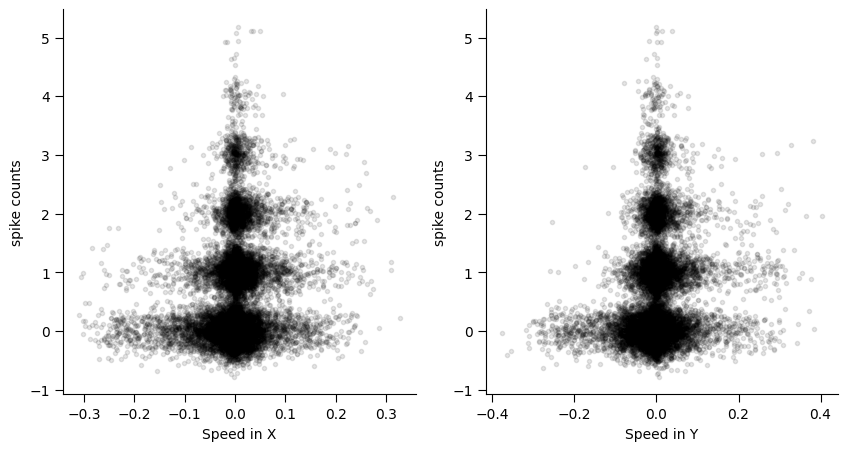

In [15]:
plt.figure(figsize=(10,5))

# Use jitter on the y axis for vizualization of trends
y_noise = np.random.randn(np.size(y))
nnoise = 0.2

plt.subplot(121)
simpleaxis(plt.gca())

plt.plot(data['handVel_x'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.xlabel('Speed in X')
plt.ylabel('spike counts')

plt.subplot(122)
simpleaxis(plt.gca())

plt.plot(data['handVel_y'], y+nnoise*y_noise, 'k.', alpha=0.1)
plt.xlabel('Speed in Y')
plt.ylabel('spike counts')

plt.show()

Now we can fit the data using a method from above:

In [16]:
#We'll store results here.
Models = dict()

In [20]:
Yt_hat, PR2 = fit_cv(X, y.astype(np.float64), algorithm = 'glm_pyglmnet', n_cv=8, verbose=2)

Models['glm'] = dict()
Models['glm']['Yt_hat'] = Yt_hat
Models['glm']['PR2'] = PR2

...runnning cv-fold 1 of 8
pR2:  0.04194389101640672
...runnning cv-fold 2 of 8
pR2:  0.0384903418513286
...runnning cv-fold 3 of 8
pR2:  0.0531632557259637
...runnning cv-fold 4 of 8
pR2:  0.04059481312751978
...runnning cv-fold 5 of 8
pR2:  0.05284021849783982
...runnning cv-fold 6 of 8
pR2:  0.04659074144569808
...runnning cv-fold 7 of 8
pR2:  0.05154937482553601
...runnning cv-fold 8 of 8
pR2:  0.04343244648311484
pR2_cv: 0.046076 (+/- 0.001928)


Or all at once:

In [23]:
methods = ['nn','xgb_run','rf','knn']

for method in methods:
    print('Running '+method+'...')
    Yt_hat, PR2 = fit_cv(X, y, algorithm = method, n_cv=8, verbose=1)
    Models[method] = dict()
    Models[method]['Yt_hat'] = Yt_hat
    Models[method]['PR2'] = PR2

Running nn...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step
pR2_cv: 0.106303 (+/- 0.003705)
Running xgb_run...
pR2_cv: 0.153868 (+/- 0.004047)
Running rf...
pR2_cv: 0.152942 (+/- 0.007841)
Running knn...
pR2_cv: -1.448570 (+/- 0.113684)


Now we can make the ensemble. 

Note that the ensemble should really be trained on predictions from 1st-stage models that were not trained on the ensemble's test set. This is not the case in a normal CV scheme. We could be slightly overfitting below. 

In [24]:
methods = ['glm','nn','xgb_run','rf','knn']
X_ens = list()
for method in methods:
    X_ens.append(Models[method]['Yt_hat'])
    
# The columns of X_ens are the predictions of each of the above methods
X_ens = np.transpose(np.array(X_ens))

#We can use XGBoost as the 2nd-stage model
Yt_hat, PR2 = fit_cv(X_ens, y, algorithm = 'xgb_run', n_cv=8, verbose=1)
Models['ens_xgb'] = dict()
Models['ens_xgb']['Yt_hat'] = Yt_hat
Models['ens_xgb']['PR2'] = PR2

#Let's also test the weighted model average.
Yt_hat, PR2 = fit_cv(X_ens, y, algorithm = 'lin_comb', n_cv=8, verbose=1)
Models['ens'] = dict()
Models['ens']['Yt_hat'] = Yt_hat
Models['ens']['PR2'] = PR2

pR2_cv: 0.162097 (+/- 0.005016)
pR2_cv: 0.160243 (+/- 0.007504)


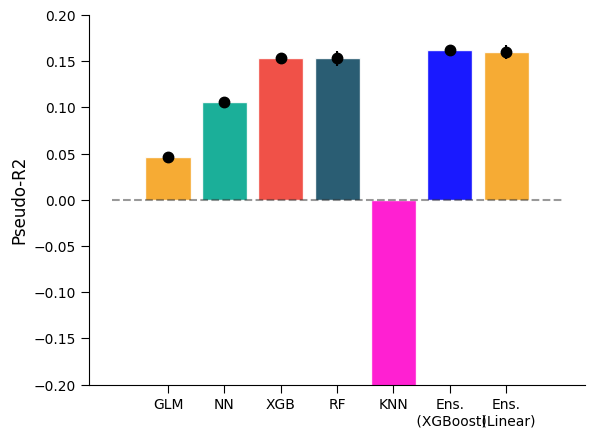

In [25]:
plot_model_comparison(['glm', 'nn','xgb_run','rf','knn','ens_xgb','ens'],models=Models,
                      color=colors,labels = ['GLM','NN','XGB','RF','KNN','Ens.\n (XGBoost)','Ens.\n (Linear)'])
plt.ylim((-.2,.2));

Though the KNN worse than the mean in this case; it could possibly be omitted (as it was in the paper).

__We're (mostly) done!__ These are the basics of running these methods. To improve all methods, we can add more features. These could be the predicted spike history, representing wholly new information, or simply engineered function of the original features (as done below).

### Use engineered features

We can get better performance on all methods by engineering the features. 

In [26]:
print('Features are:\n %s' %list(data.drop('time', axis=1).keys()))

X = data.drop('time', axis=1).values

neuron_n = 1
y = m1_imported['spikes'][neuron_n]

Features are:
 ['handPos_x', 'handPos_y', 'handVel_x', 'handVel_y', 'velDir', 'cos_velDir', 'sin_velDir', 'speed', 'cos_PosDir', 'sin_PosDir', 'radial_Pos']


In [28]:
methods = ['glm_pyglmnet','nn','xgb_run','rf','knn']

for method in methods:
    print('Running '+method+'...')
    Yt_hat, PR2 = fit_cv(X, y.astype(np.float64), algorithm = method, n_cv=8, verbose=1)
    Models[method+'_engineered'] = dict()
    Models[method+'_engineered']['Yt_hat'] = Yt_hat
    Models[method+'_engineered']['PR2'] = PR2
    
print('Running ensemble...')
# Put the previous results in a new data matrix
X_ens = list()
for method in methods:
    X_ens.append(Models[method+'_engineered']['Yt_hat'])
X_ens = np.transpose(np.array(X_ens))

#We can use XGBoost as the 2nd-stage model
Yt_hat, PR2 = fit_cv(X_ens, y, algorithm = 'xgb_run', n_cv=8, verbose=1)
Models['ens_xgb_engineered'] = dict()
Models['ens_xgb_engineered']['Yt_hat'] = Yt_hat
Models['ens_xgb_engineered']['PR2'] = PR2

Yt_hat, PR2 = fit_cv(X_ens, y, algorithm = 'lin_comb', n_cv=8, verbose=1)
Models['ens_engineered'] = dict()
Models['ens_engineered']['Yt_hat'] = Yt_hat
Models['ens_engineered']['PR2'] = PR2

Running glm_pyglmnet...
pR2_cv: 0.101865 (+/- 0.003693)
Running nn...
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
pR2_cv: 0.106201 (+/- 0.003503)
Running xgb_run...
pR2_cv: 0.151334 (+/- 0.004137)
Running rf...
pR2_cv: 0.154075 (+/- 0.005609)
Running knn...
pR2_cv: -1.511966 (+/- 0.088065)
Running ensemble...
pR2_cv: 0.157535 (+/- 0.004284)
pR2_cv: 0.158675 (+/- 0.004696)


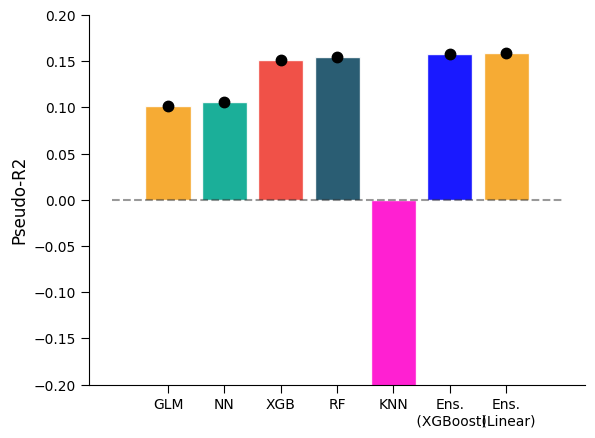

In [29]:
plot_model_comparison(['glm_pyglmnet_engineered','nn_engineered','xgb_run_engineered','rf_engineered','knn_engineered','ens_xgb_engineered','ens_engineered']
                      ,models=Models, color=colors,labels = ['GLM','NN','XGB','RF','KNN','Ens.\n (XGBoost)','Ens.\n (Linear)'])

plt.ylim((-.2,.2));

Looks like the tree-based methods (XGBoost and Random Forest) perform the best. The ensemble leverages this performance.

## Introduce nested CV scheme
#### An optional excursion to ensure the our ensemble's scores are accurate

As mentioned, the ensemble could be overfitting the noise specific to its test set if it's trained on predictions from models that were themselves trained on the test set. This is a problem if we want accurate scores to be used for method comparision. To get around it we'll implement the following scheme.

First, the data is split into _p_ folds. These are our 'outer' folds. Each fold contains a test set and a training set for the ensemble.

In each of the _p_ folds, we need to build the training set. This we'll accomplish by normal _k_-fold CV for each of our 1st-stage methods. Rotating through the _k_ folds, training and predicting our 1st-stage methods _k_ times, will result in a full training set of predictions. 

We'll also need the test set. This we can accomplish by training our 1st stage methods on the whole training set, and predicting the test set. This part is just normal _p_-fold CV.

Now we have a training set and a test set for the ensemble, so we'll train, predict, and test it. This completes the first fold! 

After repeating the same process on each of the _p_ folds, we'll have predictions of the neural response for the entire dataset, and _p_ psuedo-$R^2^ scores for the ensemble. We'll have trained the 1st stage method _p(k+1)_ times throughout this process, so it can be quite computationally demanding. It's up to the user to decide if this computational cost is worth the guarantee that the ensemble's score is not inflated because of information leakage.



In [46]:
# These two methods implement the above scheme. We don't want to be forced to run the ensemble 
# at the same time as we train the other methods on each fold, so we'll save the 1st-stage predictions for later
# and use separate methods for training a 1st-stage method and the 2nd-stage method. This will make more sense
# when we implement this.

# Basically, the first method is used to train a 1st-stage method, and the 2nd to train a 2nd-stage method.


def fit_nested_cv(X, Y, algorithm = 'glm_pyglmnet', n_cv_outer=5,n_cv_inner=5, verbose=1):
    """Outputs a list of n_cv_outer prediction vectors Yt_hats, each with length size(Y).
    
    n_cv_outer is p, in the notation above, and n_cv_inner is k.
    
    Each prediction vector will be used to train and test a single fold of the ensemble 
    in the method `ensemble_cv`. """
    
    if np.ndim(X)==1:
        X = np.transpose(np.atleast_2d(X))

    # indices of outer test/train split for each fold
        # It is imperative that the random state be identical to the random state of the Kfold used
        # in ensemble_cv
    cv_kf = KFold(n_splits=n_cv_outer, shuffle=True, random_state=42)
    skf  = cv_kf.split(X)

    i=1
    Y_hat=np.zeros((len(Y),n_cv_outer))
    pR2_cv = list()
    # In outer loop, we rotate the test set through the full dataset
    for idx_r, idx_t in skf:
        if verbose > 1:
            print( '...runnning outer cv-fold', i, 'of', n_cv_outer)
       
        Xr_o = X[idx_r, :] # train set input
        Yr_o = Y[idx_r] # train set output
        Xt_o = X[idx_t, :] # test set input
        Yt_o = Y[idx_t] # test set output (used for scoring ensemble only)
        
        
        cv_kf_in = KFold(n_splits=n_cv_inner, shuffle=True, random_state=42)
        skf_inner  = cv_kf_in.split(Xr_o)
        
        j=1
        # In the inner loop, we perform CV to predict the full validation set Yr_o, which will be recorded
        # to be used for ensemble training. THEN we use the full Xr_o to predict values for Xt_o, which will
        # be used for ensemble evaluation.
        for idx_r_inner, idx_t_inner in skf_inner:
        
            j+=1
            Xr = Xr_o[idx_r_inner, :]
            Yr = Yr_o[idx_r_inner]
            Xt = Xr_o[idx_t_inner, :]
            Yt = Yr_o[idx_t_inner]
            # Predict a fold of the Yr_o (validation)
            Yt_hat = eval(algorithm)(Xr, Yr, Xt)
            
            full_indices = idx_r[idx_t_inner] # indices of inner loop
            Y_hat[full_indices,i-1] = Yt_hat

            Yt_hat.reshape(Yt.shape)
            pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
            pR2_cv.append(pR2)

            if verbose > 1:
                print( 'pR2: ', pR2)
                
        # Now predict the ensemble's test set
        Yt_hat = eval(algorithm)(Xr_o, Yr_o, Xt_o)
        Y_hat[idx_t,i-1] = Yt_hat
        pR2 = poisson_pseudoR2(Yt_o, Yt_hat, np.mean(Yr_o))
        pR2_cv.append(pR2)
                
        i+=1

    if verbose > 0:
        print("pR2_cv: %0.6f (+/- %0.6f)" % (np.mean(pR2_cv),
                                             np.std(pR2_cv)/np.sqrt(n_cv_inner*n_cv_outer)))

    return Y_hat, pR2_cv


def ensemble_cv(X_list, Y, algorithm = 'glm_pyglmnet', n_cv_outer=5, verbose=1):
    """Outputs the scores and prediction of the ensemble on held-out data.
    
    X = list of (size(Y),n_cv_outer) np array. Each array is a previously trained method's predictions 
    all single folds. It should be of dimension (np.size(Y),n_cv_outer).
    
    It is necessary that n_cv_outer and the random state of the KFold be the same as
    in `fit_nested_cv`. """
    
    for x in X_list:
        assert x.shape == (np.size(Y),n_cv_outer)
        

    # indices of outer test/train split for each fold
    cv_kf = KFold(n_splits=n_cv_outer, shuffle=True, random_state=42)
    skf  = cv_kf.split(X_list[0])

    i=0
    Y_hat=np.zeros(len(Y))
    pR2_cv = list()
    for idx_r, idx_t in skf:
        
        # Get the first fold from each list
        X = np.array([x[:,i] for x in X_list])
        X = X.transpose()
        
        Xr = X[idx_r, :]
        Yr = Y[idx_r]
        Xt = X[idx_t, :]
        Yt = Y[idx_t]
        
        i+=1
        if verbose > 1:
            print( '...runnning cv-fold', i, 'of', n_cv_outer)
        
        Yt_hat = eval(algorithm)(Xr, Yr, Xt)
        Y_hat[idx_t] = Yt_hat
        
        pR2 = poisson_pseudoR2(Yt, Yt_hat, np.mean(Yr))
        pR2_cv.append(pR2)

        if verbose > 1:
            print( 'pR2: ', pR2)

        

    if verbose > 0:
        print("pR2_cv: %0.6f (+/- %0.6f)" % (np.mean(pR2_cv),
                                             np.std(pR2_cv)/np.sqrt(n_cv_outer)))

    return Y_hat, pR2_cv


Let's run this on the same neuron above and see if there's a difference in the ensemble score

In [47]:
methods = ['glm_pyglmnet','nn','xgb_run','rf','knn']

X_ens = list()
for method in methods:
    print('Running '+method+'...')
    Yt_hat, PR2 = fit_nested_cv(X, y, algorithm = method ,n_cv_outer=8)
    Models[method+'_nested'] = dict()
    Models[method+'_nested']['Yt_hat'] = Yt_hat
    Models[method+'_nested']['PR2'] = PR2
    # Put the previous results in a new data matrix
    X_ens.append(Yt_hat)

print('Running ensemble...')


Yt_hat, PR2 = ensemble_cv(X_ens, y, algorithm = 'xgb_run', n_cv_outer=8, verbose=1)
Models['ens_nested'] = dict()
Models['ens_nested']['Yt_hat'] = Yt_hat
Models['ens_nested']['PR2'] = PR2

pR2_cv: 0.159959 (+/- 0.004044)


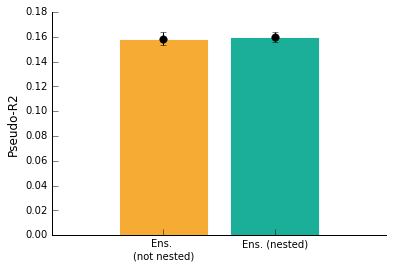

In [48]:
plot_model_comparison(['ens_engineered','ens_nested']
                      ,models=Models, color=colors,labels = ['Ens. \n(not nested)','Ens. (nested)'])

__We can see that the nested CV scheme didn't make much of a difference on this dataset. For now we can assume that normal k-fold CV is not overfitting the data.__

## Run over all neurons in the dataset

In the publication we tested 4 feature sets for the M1 dataset. Here we'll just run over the engineered feature set.

This is currently set up to run normal CV scheme. This for for expediency; with this dataset and these methods, the nested CV scheme took our machine several hours to run.

In [ ]:
methods = ['glm_pyglmnet','nn','xgb_run','rf','knn']

# We'll store both the predictions and the psuedo-R2 score in a dictionary for each 
for method in methods:
    Models[method+'_all'] = dict()
    Models[method+'_all']['PR2']  = list()
    Models[method+'_all']['Yt_hat']  = list()
Models['ens_all'] = dict()
Models['ens_all']['Yt_hat'] = list()
Models['ens_all']['PR2'] = list()

nneurons = np.shape(m1_imported['spikes'])[0]
for i in range(nneurons):
    
    print('\n running for neuron %d' % i)
    
    y = m1_imported['spikes'][i]

    for method in methods:
        print('Running '+method+'...')
        Yt_hat, PR2 = fit_cv(X, y, algorithm = method, n_cv=8, verbose=1)
     
        Models[method+'_all']['Yt_hat'].append(Yt_hat)
        Models[method+'_all']['PR2'].append(PR2)
        
    print('Running ensemble...')
    # Put the previous results in a new data matrix
    X_ens = list()
    for method in methods:
        X_ens.append(Models[method+'_all']['Yt_hat'][i])
    X_ens = np.transpose(np.array(X_ens))

    Yt_hat, PR2 = fit_cv(X_ens, y, algorithm = 'xgb_run', n_cv=8, verbose=1)
    Models['ens_all']['Yt_hat'].append(Yt_hat)
    Models['ens_all']['PR2'].append(PR2)


 running for neuron 0
Running glm_pyglmnet...
pR2_cv: 0.019708 (+/- 0.002247)
Running nn...
pR2_cv: 0.025202 (+/- 0.003476)
Running xgb_run...
pR2_cv: 0.043901 (+/- 0.003588)
Running rf...
pR2_cv: 0.030623 (+/- 0.004210)
Running knn...
pR2_cv: -2.723586 (+/- 0.165410)
Running ensemble...
pR2_cv: 0.039113 (+/- 0.004420)

 running for neuron 1
Running glm_pyglmnet...
pR2_cv: 0.050800 (+/- 0.001905)
Running nn...
pR2_cv: 0.107952 (+/- 0.003695)
Running xgb_run...
pR2_cv: 0.151781 (+/- 0.004155)
Running rf...
pR2_cv: 0.153035 (+/- 0.007690)
Running knn...
pR2_cv: -1.448570 (+/- 0.113684)
Running ensemble...
pR2_cv: 0.160966 (+/- 0.004447)

 running for neuron 2
Running glm_pyglmnet...
pR2_cv: 0.068629 (+/- 0.002075)
Running nn...
pR2_cv: 0.081361 (+/- 0.003728)
Running xgb_run...
pR2_cv: 0.116009 (+/- 0.003960)
Running rf...
pR2_cv: 0.110817 (+/- 0.009056)
Running knn...
pR2_cv: -1.435584 (+/- 0.083983)
Running ensemble...
pR2_cv: 0.117260 (+/- 0.005539)

 running for neuron 3
Running glm

This is a method for nicely plotting the scores of methods over an entire dataset:

In [73]:
import mpl_toolkits.axes_grid.inset_locator as il

def bootstrap(yy):
    # sample with replacement
    means = []
    N = 1000
    for i in range(N):
        yy_samp = np.random.choice(yy,len(yy))
        means.append(np.mean(yy_samp))
    means = np.sort(means)
    crit05 = int(0.025*N)
    crit95 = int(0.975*N)
    return np.abs(np.mean(yy)-means[[crit05,crit95]])

def plot_scatter(models_,ax_ran=[0, 0.2, 0, 0.2],ts=16,models = Models,labels = None):
    """Plots scores as a scatter plot with an inset of the population mean.
    
    models_ = list of strings of the methods to plot. First in the list is the x-axis, rest are scatter.
                The strings should be keys in the dict `models`.
    ax_ran = the plotting range. Given to plt.axis
    ts = label size
    models = dictionary that contains results of methods.
    labels = list of labels for inset bar chart. Defaults to the keys of the dictionary. """
    
    if labels is None:
        labels = models_
    
    glm_ = models_[0]
    sn = np.sqrt(len(np.array(models[glm_]['PR2'][1])))
    xx = np.mean(np.array(models[glm_]['PR2']), axis=1)
    xerr = np.std(np.array(models[glm_]['PR2']), axis=1)/sn
    alpha_lines = 0.3
    alpha = 1
    lim = ax_ran[1]
    i=0
    p = []
    
    means=[np.mean(xx)]
    mean_err = bootstrap(xx)
    
    for mod in models_[1:]:
        yy = np.mean(np.array(models[mod]['PR2']), axis=1)
        yerr = np.std(np.array(models[mod]['PR2']), axis=1)/sn
       
       
        ## uncomment to plot error
        #p1,c,b=plt.errorbar(xx, yy,fmt=marks[i], xerr = xerr, yerr = yerr ,ms=msize[i], alpha=1,color=colors[i+1])
        p1,=plt.plot(xx, yy, '.', ms=10, alpha=.5,color=colors[i+1])
        
        p.append(p1)
        plt.plot([-lim, lim], [-lim, lim], 'k:', lw=1, alpha=alpha_lines)
        
        i+=1
        
        means.append(np.mean(yy))
        mean_err = np.vstack((mean_err,bootstrap(yy)))

        
    ax = plt.gca()
    simpleaxis(ax)

    plt.xlabel('GLM pseudo-$R^2$',fontsize=ts)
    plt.ylabel('Modern ML pseudo-$R^2$',fontsize=ts)
    plt.axis(ax_ran)
            
    ax.set_yticks([0], minor=True)
    ax.set_xticks([0], minor=True)
    plt.grid(which='minor')
    
    # insert bar chart that is the average
    
    freq = np.round(1.5*np.max(means)/5,2)
    if freq<0.01:
        freq = np.round(np.max(means)/5,3)

    
    inset_axes = il.inset_axes(ax, 
                    width="40%", # width = 34% of parent_bbox
                    height="50%", # height : 1 inch
                    loc=7, borderpad = 1.5,
                    axes_kwargs = {'title':'Mean p$R^2$',
                                   'yticks':np.arange(0,np.max(means)*1.5,freq),
                                   'ylim':[-np.max(means)*.1,np.max(means)*1.5] })
    

    plt.bar(np.arange(np.size(means)), means, 0.8, align='center',
            ecolor='k', alpha=.9, color=colors, ec='w',yerr = mean_err.transpose(),
            tick_label=labels)
    plt.plot([-.6,len(labels)-.6],[0,0],color='black',)


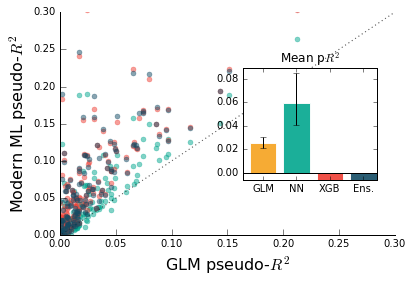

In [74]:
plot_scatter(['glm_pyglmnet_all','nn_all','xgb_run_all','ens_all'],ax_ran=[0, 0.3, 0, 0.3],ts=16,
             models = Models,labels = ['GLM','NN','XGB','Ens.'])
plt.show()

Note that the GLM has not been optimized on this feature set for this tutorial. We managed in the paper to bring it to the level of the NN. Our parameters for XGBoost could be improved, too. Here we observe that it performs better in general (as seen in the scatter) but that some outliers were overfit and are pulling down the mean scores. 

To improve the methods, we can optimize their parameters with the following method in Appendix 1.

## Appendix 1: Hyperparameter optimization

Each of the above methods has a number of parameters that can be changed. Selecting the correct values isn't trivial, and can have a very large effect on the output score. Since the 'model parameters' already means something else, these tunable parameters are called 'hyperparameters'. 

Scikit-learn has number of methods for finding hyperpameters ("see here"[http://scikit-learn.org/stable/modules/grid_search.html]). These include grid and randomized search.

We're a fan of Bayesian Optimization, since it seems a bit smarter. There are a number of implementations of this; we chose to use BayesOpt. __(Running this method will require installing this "package"[https://github.com/fmfn/BayesianOptimization])__ The following method is given as an example. The method is a bit convoluted and perphaps messy (sorry!) but is designed for ease-of-use. Here, we optimize for XGBoost.

In [ ]:

from bayes_opt import BayesianOptimization
from sklearn.cross_validation import train_test_split

def bayes_opt_xgb(X,y,xgbBO=None, num_iter=10):
    """Return an optmized XGB for a dataset. Allows warm start; can pass Bayes_opt object from previous run."""
    # Optimize on a held-out set.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    params=dict()
    
    # BayesOpt optimizes any function that takes parameters and returns a score. 
    # We need to define a function like this for XGBoost. That's what xgb_evaluate does.
    def xgb_evaluate(min_child_weight,
                     colsample_bytree,
                     max_depth,
                     subsample,
                     gamma,
                     learning_rate,
                     n_estimators):


        params['min_child_weight'] = int(min_child_weight)
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['max_depth'] = int(max_depth)
        params['subsample'] = max(min(subsample, 1), 0)
        params['gamma'] = max(gamma, 0)
        params['learning_rate'] = max(learning_rate, 0)
        params['n_estimators'] = max(n_estimators, 0)

        
        # This actually creates the instance of XGBoost. It will be fed to fit_cv, which will output the score.
        def xgb_new(Xr, Yr, Xt):
            params['objective']= "count:poisson" #for poisson output
            params['eval_metric']= "logloss" #loglikelihood loss
            params['seed']= 2925 #for reproducibility
            params['silent']= 1
            params['nthread'] = -1 #with -1 it will use all available threads

            dtrain = xgb.DMatrix(Xr, label=Yr)
            dtest = xgb.DMatrix(Xt)

            num_round = 200
            bst = xgb.train(params, dtrain, num_round)

            Yt = bst.predict(dtest)
            return Yt

        Yt_hat, PR2 = fit_cv(X_train, y_train, xgb_new, n_cv=6, verbose=0, label=[])

        return np.mean(PR2)

    random_state = 2016
  

    if not xgbBO:  #allow warm start. If starting from scratch, do:
        init_points=1
        
        # Here is where we set the bounds of the parameters to explore.
        xgbBO = BayesianOptimization(xgb_evaluate, {'min_child_weight': (1, 10),
                                                    'colsample_bytree': (1, 1),
                                                    'max_depth': (1, 10),
                                                    'subsample': (0.5, 1),
                                                    'gamma': (0, 0.4),
                                                    'learning_rate': (0.05, 0.25),
                                                    'n_estimators':(10, 1000)
                                                    },verbose=1)
        # can place results of previous runs here to improve performance
        xgbBO.explore( {'colsample_bytree': [1,1.0,1,1],
                        'gamma': [0.21173851024558027,0.4,0.2199632,0.18957],
                        'learning_rate': [0.10848417655111556,0.05,0.0952752,0.099619],
                        'max_depth': [2.097849266768804,8.1, 1.3364514,2.39364],
                        'min_child_weight': [8.85532939789740331,1,3.06446781,6.33840],
                        'n_estimators': [900.3009605914325,511,190.8645, 925.70248],
                        'subsample': [0.83434308305954963,0.5,0.85830945,0.798837]})  

    
    else:
         init_points = 2

    # This is the actual optimization method.
    xgbBO.maximize(init_points=init_points, n_iter=num_iter, xi=0.0)
    values = xgbBO.res['max']
    print(values)
    
  
    #want to return an optmized method for later use!! We can also see the parameters by typing xgbBO.res['max']
    params = values['max_params']
    def xgb_best(Xr, Yr, Xt,returnModel=0):
            params['min_child_weight'] = int(params['min_child_weight'])
            params['max_depth'] = int(params['max_depth'])
            params['objective']= "count:poisson" #for poisson output
            params['eval_metric']= "logloss" #loglikelihood loss
            params['seed']= 2925 #for reproducibility
            params['silent']= 1
            params['nthread'] = -1 #with -1 it will use all available threads
            params['colsample_bytree']= 1.0

            dtrain = xgb.DMatrix(Xr, label=Yr)
            dtest = xgb.DMatrix(Xt)

            num_round = 200
            bst = xgb.train(params, dtrain, num_round)

            Yt = bst.predict(dtest)
            if returnModel:
                return bst
            else: 
                return Yt
    return xgb_best, xgbBO

This method can be used as follows.

In [ ]:
XGB_optimized, xgbBO_optimized = bayes_opt_xgb(X,y,num_iter=5)

Yt_hat, PR2 = fit_cv(X, y, algorithm = 'XGB_optimized', n_cv=10, verbose=1, label=[])

## Appendix 2: GLM implemented with R's glmnet.

Since the GLM depends on a proper learning rate, regularization path, etc., it can be helpful to compare with other packages with different defaults. The package in R (glmnet) is pretty robust. If it is desired to compare the two GLMs, one can use R's glmnet in python with the following method (designed to interface with `fit_cv`).

This requires the installation of rpy2.

In [ ]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri as n2r
n2r.activate()

r = ro.r
r.library('glmnet')


def r_glmnet(Xr,Yr,Xt):
    yr = ro.FloatVector(Yr) 
    trained_model = r['glmnet'](Xr, yr, family="poisson",alpha = 0.1)
    lambda_min = np.asanyarray(trained_model.rx2('lambda'))[-1]
    Yt = r['predict'](trained_model,s=lambda_min,newx=Xt,type="response")
#     betas = np.asanyarray(r['as.matrix'](trained_model.rx2('beta')))[:,-1]
#     beta0 = np.asanyarray(r['as.matrix'](trained_model.rx2('a0')))[-1]
#     print(betas,beta0)
    return np.array(list(Yt))